In [1]:
!pip install tensorflow keras nltk spacy-stanza

In [2]:
import tensorflow as tf
import json
import pickle
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random
from keras.layers.normalization.batch_normalization import BatchNormalization


from utils import *

2021-12-17 16:11:45.516819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-17 16:11:45.516854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2021-12-17 16:11:49 INFO: Downloading default packages for language: es (Spanish)...
2021-12-17 16:11:50 INFO: File exists: /home/user/stanza_resources/es/default.zip.
2021-12-17 16:11:56 INFO: Finished downloading models and saved to /home/user/stanza_resources.
2021-12-17 16:11:56 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-12-17 16:11:56 INFO: Use device: cpu
2021-12-17 16:11:56 INFO: Loading: tokenize
2021-12-17 16:11:56 INFO: Loading: mwt
2021-12-17 16:11:56 INFO: Loading: pos
2021-12-17 16:11:56 INFO: Loading: lemma
2021-12-17 16:11:56 INFO: Loading: depparse
2021-12-17 16:11:57 INFO: Loading: ner
2021-12-17 16:11:58 INFO: Done loading processors!


In [3]:
words=[]
classes = []
documents = []
data_file = open('intents.json').read()
intents = json.loads(data_file)

In [4]:
#tokenizing
for intent in intents['intents']:
    for pattern in intent['patterns']:
        #tokenizing
        w= tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [5]:
classes

['saludo', 'despedida', 'opciones', 'alimentos_sanos', 'alimentos_no_sanos']

In [6]:
fulltext = ' '.join(words)
# lemmatize, lower each word and remove duplicates
lemmas = lemmatize_without_stop(fulltext)
lemmas = sorted(list(set(lemmas)))
# sort classes
classes = sorted(list(set(classes)))

#removing accent and signs
lemmas = remove_accent_punct(lemmas)


/home/user/code/jupyterenvironment/lib/python3.9/site-packages/stanza/models/common/beam.py:86: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prevK = bestScoresId // numWords


In [7]:
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(lemmas), "unique lemmatized words", lemmas)

26 documents
5 classes ['alimentos_no_sanos', 'alimentos_sanos', 'despedida', 'opciones', 'saludo']
28 unique lemmatized words ['adios', 'ayudar', 'buen', 'carbohidrato', 'chao', 'chatarra', 'conocer', 'como', 'dulce', 'dia', 'fruta', 'frutoseco', 'gusto', 'hacer', 'hey', 'holar', 'lacteo', 'luego', 'noche', 'poder', 'procesado', 'proteina', 'servir', 'snacks', 'tal', 'tarde', 'vegetal', 'ver']


In [8]:
pickle.dump(lemmas,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

## Exploring

In [9]:
len(lemmas)

28

In [10]:
documents[21]

(['frutoseco'], 'alimentos_sanos')

# TRAINING

In [11]:
# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = lemmatize_with_stop(' '.join(pattern_words))
    if (pattern_words == 'frutonecer'):
        pattern_words == 'frutoseco'
    pattern_words  = remove_accent_punct(pattern_words)
    
    # create our bag of words array with 1, if word match found in current pattern
    for w in lemmas:
        bag.append(1) if w in pattern_words else bag.append(0)
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)

print("Training data created")

Training data created


/tmp/ipykernel_245689/2241131879.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  training = np.array(training)


In [12]:
training[4:5,:]

array([[list([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        list([0, 0, 0, 0, 1])]], dtype=object)

In [13]:
# create train and test lists. X - patterns, Y - intents
datafortrain = int(len(training)*0.9)

train_x = list(training[:datafortrain,0])
train_y = list(training[:datafortrain,1])

val_x = list(training[datafortrain:,0])
val_y = list(training[datafortrain:,1])

In [14]:
path_checkpoint = "model_checkpoint.h5"
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.000000000001,patience=30),
    tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=False,
    save_best_only=True,),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [17]:
#Batch normalization
model = Sequential()
model.add(Dense(256, input_shape=(len(train_x[0]),), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
#fitting and saving the model 

hist = model.fit(np.array(train_x), np.array(train_y), epochs=10000, batch_size=4, validation_data=(val_x, val_y), verbose=True, callbacks = my_callbacks)
model.save('chatbot_model.h5', hist)

print("model created")

/home/user/code/jupyterenvironment/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/10000
1/6 [====>.........................] - ETA: 4s - loss: 2.4881 - accuracy: 0.5000
Epoch 00001: val_loss did not improve from 1.57200
6/6 [==============================] - 1s 43ms/step - loss: 2.1126 - accuracy: 0.2609 - val_loss: 1.5848 - val_accuracy: 0.3333
Epoch 2/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0736 - accuracy: 0.0000e+00
Epoch 00002: val_loss did not improve from 1.57200
6/6 [==============================] - 0s 14ms/step - loss: 2.4524 - accuracy: 0.0870 - val_loss: 1.5741 - val_accuracy: 0.3333
Epoch 3/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.1356 - accuracy: 0.2500
Epoch 00003: val_loss improved from 1.57200 to 1.56837, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 19ms/step - loss: 2.8991 - accuracy: 0.1739 - val_loss: 1.5684 - val_accuracy: 0.3333
Epoch 4/10000
1/6 [====>.........................] - ETA: 0s - loss: 4.1269 - accuracy: 0.0000e+00
Epoch 00004: val_loss improved fro

Epoch 29/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.5311 - accuracy: 0.2500
Epoch 00029: val_loss improved from 1.49397 to 1.48102, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 18ms/step - loss: 2.2759 - accuracy: 0.2609 - val_loss: 1.4810 - val_accuracy: 0.3333
Epoch 30/10000
1/6 [====>.........................] - ETA: 0s - loss: 3.0902 - accuracy: 0.2500
Epoch 00030: val_loss did not improve from 1.48102
6/6 [==============================] - 0s 11ms/step - loss: 1.8425 - accuracy: 0.3043 - val_loss: 1.4816 - val_accuracy: 0.3333
Epoch 31/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.0450 - accuracy: 0.5000
Epoch 00031: val_loss improved from 1.48102 to 1.47988, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 16ms/step - loss: 1.6402 - accuracy: 0.4783 - val_loss: 1.4799 - val_accuracy: 0.3333
Epoch 32/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.7292 - accuracy: 0.50

Epoch 56/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.3391 - accuracy: 0.2500
Epoch 00056: val_loss did not improve from 1.32622
6/6 [==============================] - 0s 21ms/step - loss: 1.5776 - accuracy: 0.5217 - val_loss: 1.3429 - val_accuracy: 0.3333
Epoch 57/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.5216 - accuracy: 0.2500
Epoch 00057: val_loss did not improve from 1.32622
6/6 [==============================] - 0s 21ms/step - loss: 1.6481 - accuracy: 0.3913 - val_loss: 1.3272 - val_accuracy: 0.3333
Epoch 58/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.4028 - accuracy: 0.2500
Epoch 00058: val_loss improved from 1.32622 to 1.31673, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 25ms/step - loss: 1.4683 - accuracy: 0.5217 - val_loss: 1.3167 - val_accuracy: 0.3333
Epoch 59/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.6816 - accuracy: 0.2500
Epoch 00059: val_loss improved from 1.

Epoch 84/10000
1/6 [====>.........................] - ETA: 0s - loss: 0.3583 - accuracy: 1.0000
Epoch 00084: val_loss improved from 1.13227 to 1.12240, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 18ms/step - loss: 1.0146 - accuracy: 0.6522 - val_loss: 1.1224 - val_accuracy: 0.6667
Epoch 85/10000
1/6 [====>.........................] - ETA: 0s - loss: 2.7203 - accuracy: 0.0000e+00
Epoch 00085: val_loss improved from 1.12240 to 1.11357, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 16ms/step - loss: 1.4157 - accuracy: 0.5217 - val_loss: 1.1136 - val_accuracy: 0.6667
Epoch 86/10000
1/6 [====>.........................] - ETA: 0s - loss: 1.8087 - accuracy: 0.5000
Epoch 00086: val_loss improved from 1.11357 to 1.09124, saving model to model_checkpoint.h5
6/6 [==============================] - 0s 17ms/step - loss: 1.6237 - accuracy: 0.4783 - val_loss: 1.0912 - val_accuracy: 0.6667
Epoch 87/10000
1/6 [====>.......................

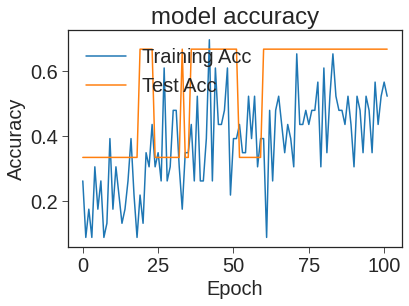

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})
plt.style.use("seaborn-ticks")

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()